In [1]:
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
#read disease-gene sets
cvd_genes = pd.read_csv('data/cvd_genes.csv')

### cvd networks

In [13]:
import graph_tool.all as gt
import networkx as nx
from disparity import disparity_filter, cut_graph

In [14]:
#create a weighted graph with jaccard similarities of CVDs
dicT = cvd_genes.groupby('efoName')['GeneId'].apply(set).to_dict()
corr_mtx = []
for a,b in combinations(dicT, 2): corr_mtx.append([a, b, len(dicT[a] & dicT[b])/len(dicT[a] | dicT[b])])
corr_mtx = pd.DataFrame(corr_mtx, columns=['A', 'B', 'w'])

In [15]:
#compute disparity p-value
nx_G = nx.Graph()
nx_G.add_weighted_edges_from(corr_mtx.values) #this adds edge weight attribute automatically
nx.set_node_attributes(nx_G, {n:n for n in nx_G.nodes()}, name='nodes')
alpha = disparity_filter(nx_G) #keep disparity p-value as an edge attribute 

In [16]:
#remove weak edges
G = gt.Graph(directed=False)
ew = G.new_ep('double')

df = pd.DataFrame(nx_G.edges(), columns = ['A', 'B'])
df['p_value'] = nx.get_edge_attributes(nx_G, 'alpha').values()
ids = G.add_edge_list(df[df.p_value < 0.05].values, hashed=True, eprops=[ew])

In [18]:
index2ids={v: ids[v] for v in G.iter_vertices()}
print('Number of Nodes/Diseases', len(index2ids) )

Number of Nodes/Diseases 65


In [32]:
#state = gt.minimize_blockmodel_dl(G)
state = gt.BlockState(G)
dS, nattempts, nmoves = state.multiflip_mcmc_sweep(niter=1000)
print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

pv = None
state.mcmc_sweep(niter=1000)   # remove part of the transient
for i in range(1000):
    ret = state.mcmc_sweep(niter=10)
    pv = state.collect_vertex_marginals(pv)

Change in description length: -93.72372384204891
Number of accepted vertex moves: 120546


In [34]:
pos = gt.sfdp_layout(G)

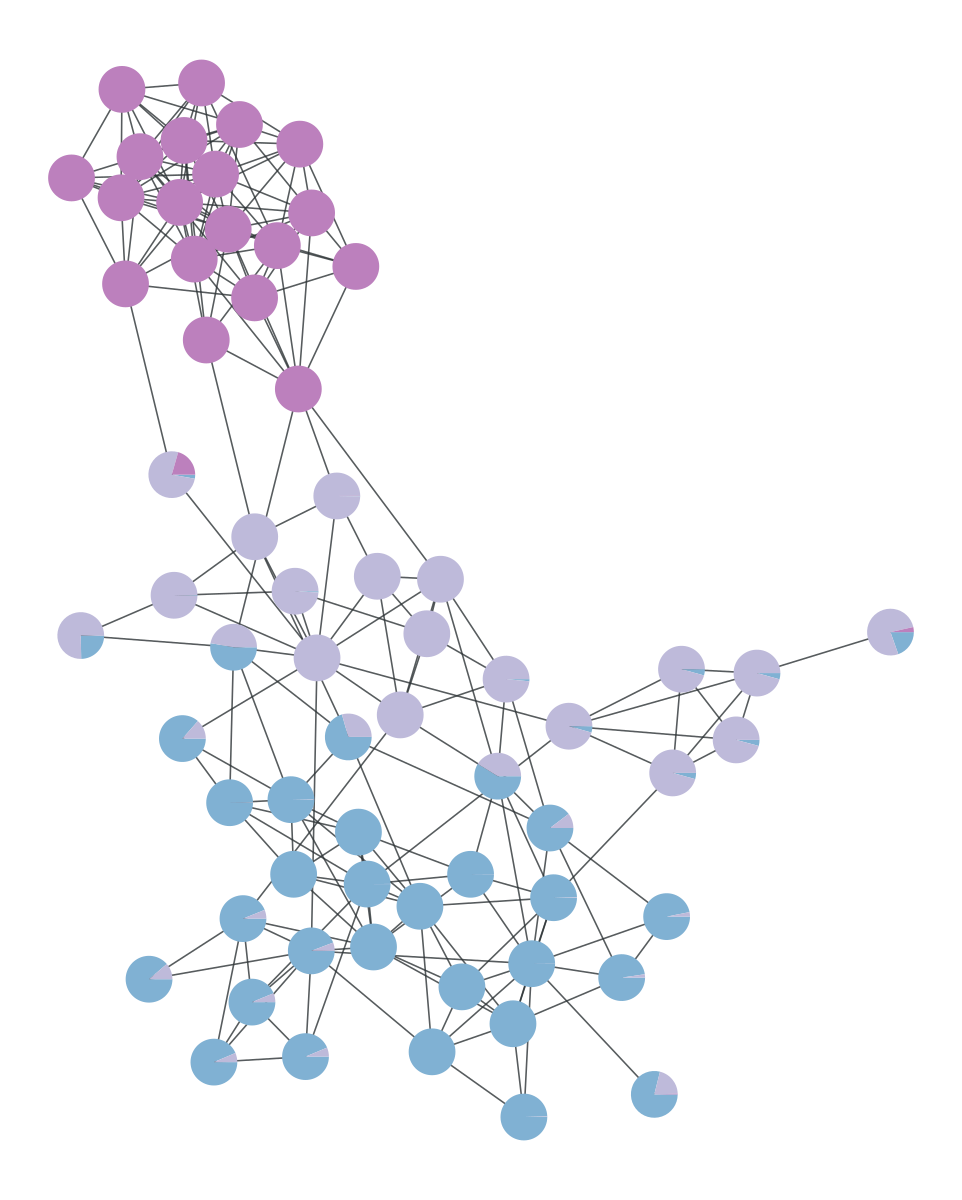

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa6256738d0, at 0x7fa624cf2310>

In [41]:
gt.graph_draw(G, pos=pos, vertex_shape="pie", vertex_pie_fractions=pv, edge_pen_width=0.8)#, output='data/out.svg')

In [38]:
# communities retrieved
set(state.get_blocks().a)

{14, 45, 52}

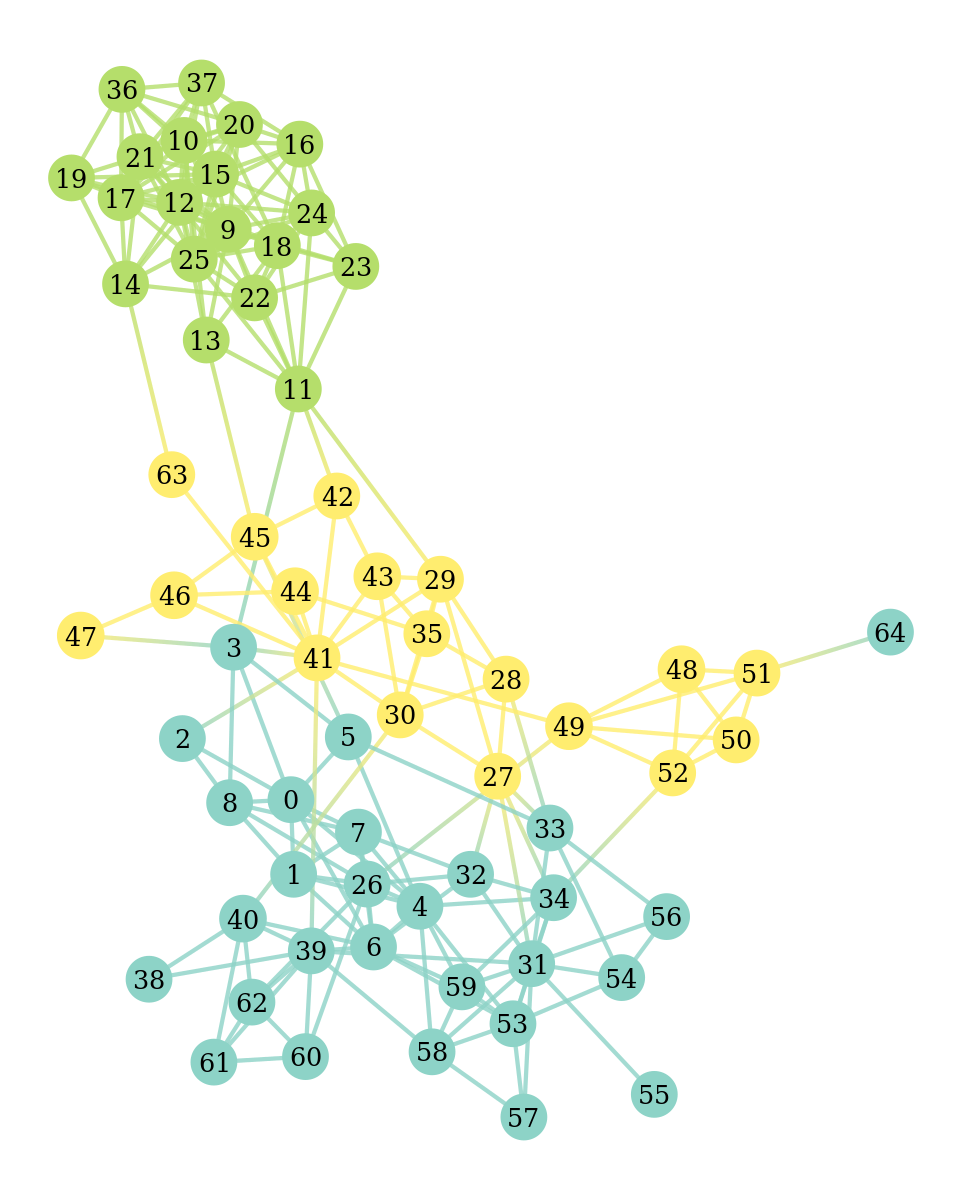

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa6256738d0, at 0x7fa5da804850>

In [40]:
state.draw(pos=pos, vertex_text=G.vertex_index)

In [43]:
index2ids

{0: 'abdominal aortic aneurysm',
 1: 'atherosclerosis',
 2: 'brain aneurysm',
 3: 'familial thoracic aortic aneurysm and aortic dissection',
 4: 'large artery stroke',
 5: 'moyamoya disease',
 6: 'peripheral arterial disease',
 7: 'peripheral vascular disease',
 8: 'thoracic aortic aneurysm',
 9: 'arrhythmogenic right ventricular dysplasia',
 10: 'autosomal dominant dilated cardiomyopathy',
 11: 'brugada syndrome',
 12: 'cardiomyopathy',
 13: 'catecholaminergic polymorphic ventricular tachycardia',
 14: 'dilated cardiomyopathy',
 15: 'familial dilated cardiomyopathy',
 16: 'familial isolated arrhythmogenic right ventricular dysplasia',
 17: 'familial isolated dilated cardiomyopathy',
 18: 'familial progressive cardiac conduction defect',
 19: 'hypertrophic cardiomyopathy',
 20: 'left ventricular noncompaction',
 21: 'rare familial disorder with hypertrophic cardiomyopathy',
 22: 'sudden cardiac arrest',
 23: 'ventricular fibrillation',
 24: 'ventricular tachycardia',
 25: 'wolff-parkin

In [47]:
pd.DataFrame(zip([ids[v] for v in G.iter_vertices()], state.get_blocks().a), columns=['cvd', 'cluster_idx']).to_csv('data/cvd_cluster.csv', index=False)